
## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---
## Perform a HOG feature extraction

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

MY_Y_START_STOP = [400, 656]
COLOR_SPACE = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
ORIENT = 9  # HOG orientations
PIX_PER_CELL = 8 # HOG pixels per cell
CELL_PER_BLOCK = 2 # HOG cells per block
HOG_CHANNEL = 'ALL' # Can be 0, 1, 2, or "ALL"
SPATIAL_SIZE = (32, 32) # Spatial binning dimensions
HIST_BINS = 32    # Number of histogram bins
SPATIAL_BINS = True # Spatial features on or off
SPATIAL_FEAT = True
HIST_FEAT = True # Histogram features on or off
HOG_FEAT = True # HOG features on or off
XY_WINDOW=(96, 96)
XY_OVERLAP=(0.5, 0.5)

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

In [3]:
# Define a function to compute binned color features  
def bin_spatial(img, size=SPATIAL_SIZE):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=HIST_BINS):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

features shape:  (7, 7, 2, 2, 9)


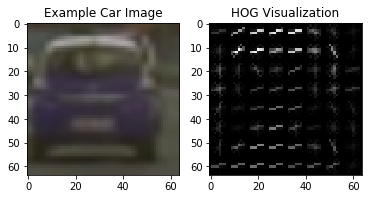

In [4]:
# Test
test_image = './vehicles/GTI_MiddleClose/image0050.png'

image = cv2.imread(test_image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, vis=True)

print("features shape: ", features.shape)
fig = plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image,cmap='gray')
plt.title('HOG Visualization')
plt.show()

## Normalization Function

In [5]:
def normalize_training(feature_list):
    # Create an array stack, NOTE: StandardScaler() expects np.float64
    X = np.vstack(feature_list).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    return scaled_X


## SVM Train and Classify

In [6]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space=COLOR_SPACE, spatial_size=SPATIAL_SIZE,
                        hist_bins=HIST_BINS, orient=ORIENT, 
                        pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK, hog_channel=HOG_CHANNEL,
                        spatial_feat=SPATIAL_FEAT, hist_feat=HIST_FEAT, hog_feat=HOG_FEAT):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features



# Divide up into cars and notcars
car_images = glob.glob('./vehicles/*/*.png')
noncar_images = glob.glob('./non-vehicles/*/*.png')

cars = []
notcars = []

for x in car_images:
    cars.append(x)

for x in noncar_images:
    notcars.append(x)
    

print("cars= {0}".format(len(cars)))
print("notcars= {0}".format(len(notcars)))

t=time.time()

car_features = extract_features(cars)
notcar_features = extract_features(notcars)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')


scaled_X = normalize_training([car_features, notcar_features])

cars= 8792
notcars= 8968
60.71 Seconds to extract HOG features...


In [7]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [8]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Feature vector length: 8460
27.4 Seconds to train SVC...
Test Accuracy of SVC =  0.9842


In [9]:
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts is : ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

My SVC predicts is :  [ 0.  0.  0.  1.  0.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  0.]
0.00211 Seconds to predict 10 labels with SVC


## Sliding Window

In [10]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=XY_WINDOW, xy_overlap=XY_OVERLAP):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

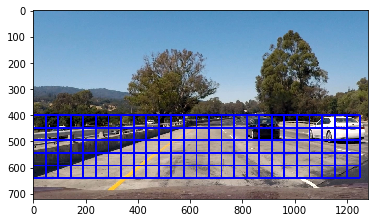

In [11]:
# test sliding window

test_image = './test_images/test1.jpg'

image = cv2.imread(test_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=MY_Y_START_STOP, 
                    xy_window=XY_WINDOW, xy_overlap=XY_OVERLAP)
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()


In [12]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features ()
# just for a single image rather than list of images
def single_img_features(img, color_space=COLOR_SPACE, spatial_size=SPATIAL_SIZE,
                        hist_bins=HIST_BINS, orient=ORIENT, 
                        pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK, hog_channel=HOG_CHANNEL,
                        spatial_feat=SPATIAL_FEAT, hist_feat=HIST_FEAT, hog_feat=HOG_FEAT):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

Result for single patch extraction ..
6


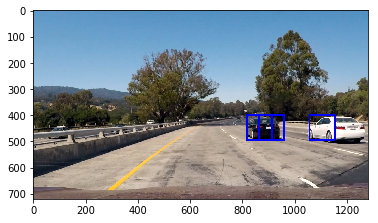

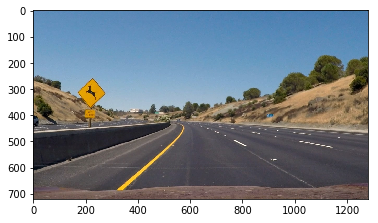

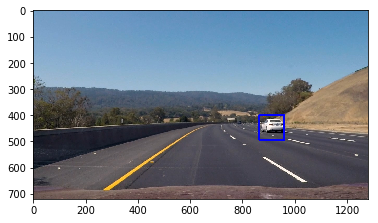

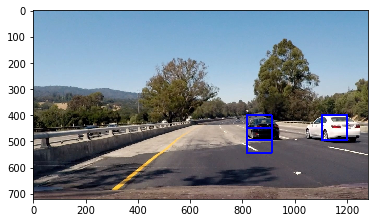

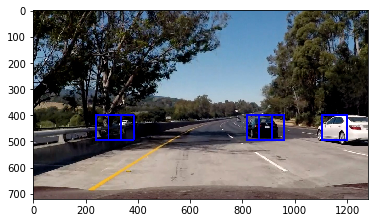

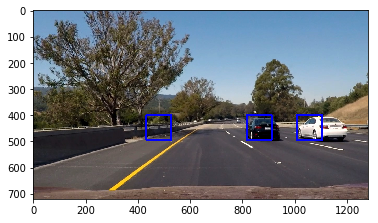

In [13]:
# test single patch

print("Result for single patch extraction ..")
test_images = glob.glob('./test_images/*.jpg')
print(len(test_images))

for test_image in test_images:
    image = cv2.imread(test_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    draw_image = np.copy(image)
    X = np.vstack([car_features, notcar_features]).astype(np.float64)
    X_scaler = StandardScaler().fit(X)

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=MY_Y_START_STOP, 
                    xy_window=XY_WINDOW, xy_overlap=XY_OVERLAP)
   
    hot_windows = search_windows(image, windows, svc, X_scaler)   

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    plt.imshow(window_img)
    plt.show()

In [14]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
# Define a single function that can extract features using hog sub-sampling and make predictions

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, hist_bins, spatial_size):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img, bbox_list


In [15]:
X = np.vstack([car_features, notcar_features]).astype(np.float64)
X_scaler = StandardScaler().fit(X)

Results for hog subsampling..
6


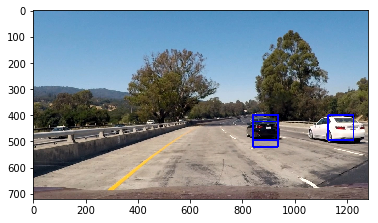

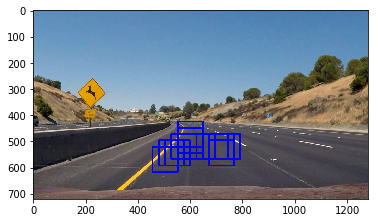

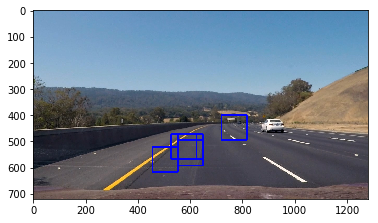

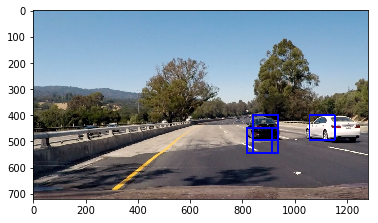

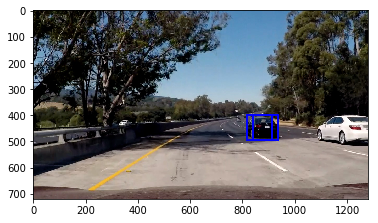

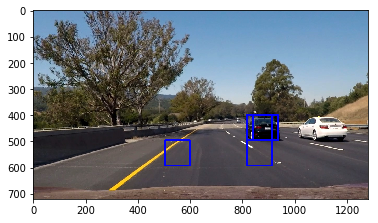

In [16]:
# find_cars hog_subsample test

print("Results for hog subsampling..")
ystart = 400
ystop = 656
scale = 1.5

test_images = glob.glob('./test_images/*.jpg')
print(len(test_images))

for test_image in test_images:
    image = cv2.imread(test_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    out_img, bbox_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient=ORIENT, pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK, 
                    hist_bins=HIST_BINS, spatial_size=SPATIAL_SIZE)
    plt.imshow(out_img)
    plt.show()

## +ve detection and removal

In [17]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


In [18]:
def gen_thresholded_heat_map(box_list, threshold):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    heat = add_heat(heat, box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)
    
    return heat
    

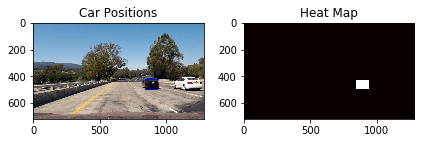

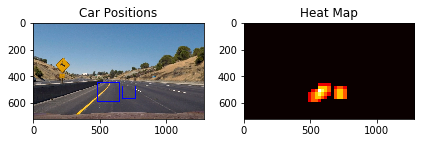

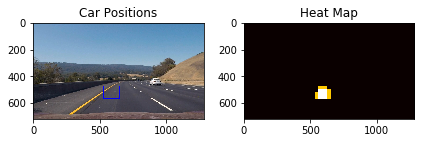

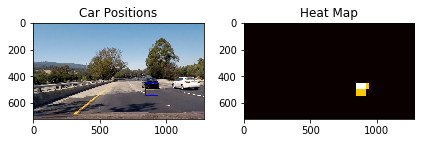

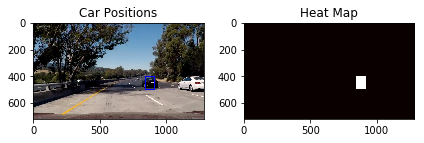

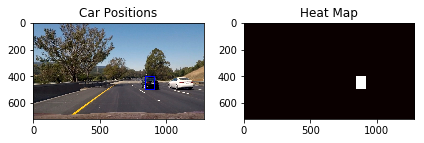

In [19]:
# test +ve detection.
# Add heat to each box in box list

test_images = glob.glob('./test_images/*.jpg')

for test_image in test_images:
    image = cv2.imread(test_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    out_img, box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, 
                    hist_bins=32, spatial_size=(32,32))
    
    #windows = slide_window(image, x_start_stop=[None, None], y_start_stop=MY_Y_START_STOP, xy_window=(96, 96), xy_overlap=(0.75, 0.75))
   
    #box_list = search_windows(image, windows, svc, X_scaler) 

    heat = gen_thresholded_heat_map(box_list, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.show()

## Tracking pipeline